In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Perceptron Demo

In this notebook, we will go through how to train a perceptron for binary classification problems.

<img src="files/images/Perceptron/classification.png" style="margin:auto; width: 330px;"/>

## What is a perceptron?

Perceptron is a artificial neural network whose learning was invented by Frak Rosenblatt in 1957.  

<img src="files/images/Perceptron/rosenblatt.jpg" style="margin:auto; width: 225px;"/>

According to wikipedia, "In a 1958 press conference organized by the US Navy, Rosenblatt made statements about the perceptron that caused a heated controversy among the fledgling AI community; based on Rosenblatt's statements, The New York Times reported the perceptron to be "the embryo of an electronic computer that [the Navy] expects will be able to walk, talk, see, write, reproduce itself and be conscious of its existence."

A perceptron is a single-layer, linear classifier:

<img src="files/images/Perceptron/diagram.png" style="margin:auto; width: 817px;"/>

Although it is very simple (and too simple for many tasks), it forms the basis for more sophisticated networks and algorithms (backpropagation).

<img src="files/images/Perceptron/diagram.png" style="margin:auto; width: 817px;"/>

A perceptron has $P$ input units, one output unit and $P+1$ weights (parameters) $w_n$.  For a particular input (a $P$-dimensional vector ${\bf x}$), the perceptron outputs

$$ t = sign( a ) = sign( {\bf x} {\bf w}^\intercal  + {\bf w}_0 ) $$

$a$ is the *activation* of the perceptrion. The "sign" function returns $+1$ for anything greater than zero and $-1$ for less than zero.

${\bf w}_0$ is called the "bias weight".  For convenience, we often change the input vector ${\bf x} = (x_1, x_2, ...)$ to have $1$ at the end (${\bf x}' = (x_1, x_2, ..., x_p, 1)$), so that we can express the activation as simply $a = {\bf x}' {\bf w}^\intercal$.

## How is perceptron trained?

Before we can discuss training, we need to clarify what we want to train for!  For binary classification problem, for each sample ${\bf x}_i$, we have a corresponding *label* $y_i \in \{ 1, -1 \}$.  $1$ corresponds to one class (red points, for example), and $-1$ corresponds to the other class (blue points).  

<img src="files/images/Perceptron/classification.png" style="margin:auto; width: 330px;"/>

By training, we mean that we want to find ${\bf w}$ such that for all $i$, $y_i = sign({\bf x}_i' {\bf w}^\intercal)$.

In other words, we want to minimize the (0/1) *loss function*

$$ J_{0/1}({\bf w}) = \frac{1}{N} \sum_{i=1}^{N} (y_i == sign({\bf x}_i' {\bf w}^\intercal))$$

This is an optimization problem.  Unfortunately, this particular loss function is practically impossible to solve, because the gradient is flat everywhere!

<img src="files/images/Perceptron/0-1loss.png" style="margin:auto; width: 330px;"/>

Instead, a perceptron learning rule minimizes the *perceptron criterion*:

$$ J({\bf w}) = \frac{1}{N} \sum_{i=1}^{N} \max (0, - y_i a_i)$$

 * If the prediction was correct - say, $y_i = 1$ and $a = 0.8$, then $-y_i a_i < 0$, so $\max(0, -y_i a_i) = 0$.  In other words, the loss is zero for correct examples.
 * If the prediction was wrong - say, $y_i = -1$ and $a = 0.8$, then the loss is *proportional* to $a_i$.  The penalty is very large when you predict very large $a_i$ and get it wrong!

It's important to note that the loss function only cares about the examples that were classified wrong.

So we can also rewrite the loss function as

$$ J({\bf w}) = \sum_{i= \textrm{Wrong samples}} - y_i a_i $$

Now we can take the derivative with respect to ${\bf w}$ and get something nicer:

$$ \frac{\partial J_i({\bf w})}{\partial w_j} = -y_i x_{ij} \quad \textrm{For wrong sample } i$$

<img src="files/images/Perceptron/perceptron_loss.png" style="margin:auto; width: 330px;"/>

And, using the stochastic gradient decent algorithm with the learning rate of $\eta$, we get the perceptron weight update rule:

$${\bf w} \leftarrow {\bf w} + \eta y_i {\bf x}_i' $$

... for all misclassified examples $i$.

(Exercise: take out your papers and pencils and convince yourself of this.)

# Training a perceptron

Now that we know how to train a perceptron, let's generate some data `X` and binary labels `y` to test on! We'll use `sklearn.datasets` to make some test data.

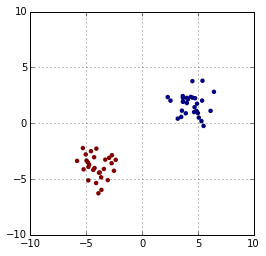

In [2]:
from sklearn.datasets import make_blobs

X = y = None # Global variables
@interact
def plot_blobs(n_samples=(10, 500),
               center1_x=1.5,
               center1_y=1.5,
               center2_x=-1.5,
               center2_y=-1.5):
    centers=array([[center1_x, center1_y],[center2_x, center2_y]])
    global X, y 
    X, y= make_blobs(n_samples=n_samples, n_features=2,
                      centers=centers, cluster_std=1.0)
    y = y*2 - 1  # To convert to {-1, 1}
    
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='none')
    plt.xlim([-10,10]); plt.ylim([-10,10]); plt.grid()
    plt.axes().set_aspect('equal')

In [22]:
from sklearn.cross_validation import train_test_split

# Plotting routine for perceptron training
def predict(w, X):
    """Returns the predictions."""
    return sign(dot(c_[X, ones((X.shape[0], 1))], w))
    
def error01(w, X, y):
    """Calculates the mean 0/1 error."""
    return 1.0 - (predict(w, X) == y).mean()

def perceptron_training(X,y,eta=0.1):
    global w, errors
    
    # Split data to training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # Plot the current predictions and the hyperplane
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(X_train[:,0], X_train[:,1], c=predict(w, X_train), edgecolor='none')
    axs[0].set_xlim([-10,10]); axs[0].set_ylim([-10,10]); axs[0].grid()
    axs[0].set_aspect('equal')
    
    # Draw the separating line
    cw=-w[2]/(w[0]**2+w[1]**2)
    ts=array([-100.0,100.0])
    axs[0].plot(-w[1]*ts+w[0]*cw, w[0]*ts+w[1]*cw, linestyle='--', color='r')
    axs[0].arrow(w[0]*cw,w[1]*cw, w[0], w[1], 
            head_width=0.5, head_length=0.5, fc='r', ec='r')    
    
    # Plot the classification errors
    train_error, test_error = [error01(w, X_, y_) for X_, y_ in [[X_train, y_train], [X_test, y_test]]]
    errors = r_[errors, array([train_error, test_error])[newaxis,:]]
    axs[1].plot(errors)
    axs[1].set_title('Classification Errors')
    axs[1].set_ylim([0,1])
    axs[1].legend(['Training','Test'])
    
    # Update w
    w = update_w_all(w, X_train, y_train, eta)


Exercise 2. implement the code to do a single step of perceptron weight update. Press the button each time to run a single step of `update_w_all`; re-evaluating the cell resets the weight and starts over.

Remember:

$${\bf w} \leftarrow {\bf w} + \eta y_i {\bf x}_i' $$

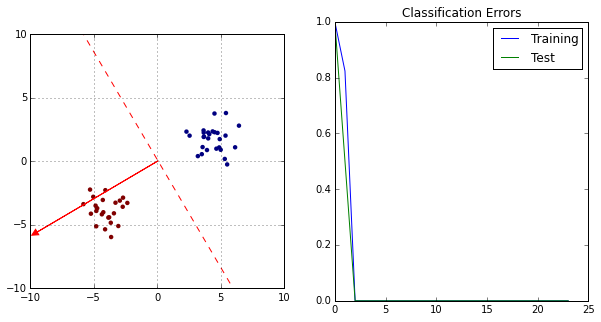

In [34]:
def _delta_w_single(w, x, y):
    """Calculates the gradient for w from the single sample x and the target y.
    
        inputs:
            w: 1 x (p+1) vector of current weights.
            x: 1 x p vector representing the single sample.
            y: the target, -1 or 1.
        
        returns:
            w: 1 x (p+1) vector of updated weights.
    """
    # TODO implement this
    return 0

def update_w_all(w, X, y, eta = 0.1):
    """Updates the weight vector for all training examples.

        inputs:
            w: 1 x (p+1) vector of current weights.
            X: N x p vector representing the single sample.
            y: N x 1 vector of the targets, -1 or 1.
            eta: The training rate. Defaults to 0.1.
        
        returns:
            w: 1 x (p+1) vector of updated weights.
    """
    for xi, yi in zip(X, y):
        w += eta * delta_w_single(w, xi, yi) / X.shape[0]
    return w

from numpy.random import random_sample 
w = random_sample(3)   # Initialize w to values from [0, 1)
errors = zeros((0, 2)) # Keeps track of error values over time
interact_manual(perceptron_training, X=fixed(X), y=fixed(y), eta=FloatSlider(min=0.01, max=1.0, value=0.1))

In [32]:
# A sample solution:

def delta_w_single(w, x, y):
    """Updates the weight vector w from the single sample x and the target y.
    
        inputs:
            w: 1 x (p+1) vector of current weights.
            x: 1 x p vector representing the single sample.
            y: the target, -1 or 1.
        
        returns:
            w: 1 x (p+1) vector of updated weights.
    """
    x_prime = r_[x, 1]
    prediction = dot(x_prime, w.T)
    if prediction != y:
        return y * x_prime
    else:
        return 0

The perceptron only works for linearly separable data.

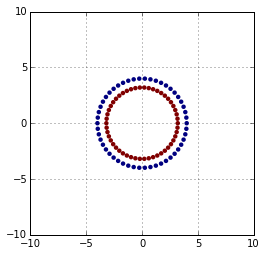

In [27]:
from sklearn.datasets import make_circles, make_moons
X_circle, y_circle = make_circles(100) # or try make_moons(100)
y_circle = y_circle * 2 - 1
X_circle*=4  # Make it a bit larger
plt.scatter(X_circle[:,0], X_circle[:,1], c=y_circle, edgecolor='none')
plt.xlim([-10,10]); plt.ylim([-10,10]); plt.grid()
plt.axes().set_aspect('equal')

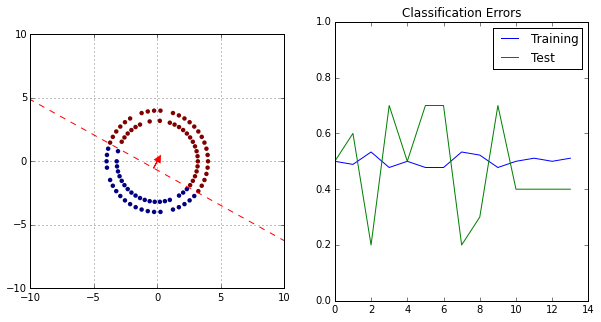

In [28]:
w = random_sample(3)   # Initialize w to values from [0, 1)
errors = zeros((0, 2)) # Keeps track of error values over time
interact_manual(perceptron_training, X=fixed(X_circle), y=fixed(y_circle), eta=fixed(0.1))